In [124]:
import os 
from scipy.io import loadmat
from scipy.signal import medfilt, savgol_filter, detrend
from statsmodels.nonparametric.smoothers_lowess import lowess
from pykalman import KalmanFilter
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from timedenoiser.models.tv1d import denoising_1D_TV
from timedenoiser.models.mctv1d import denoising_1D_MCTV
from timedenoiser.models.metv1d import denoising_1D_METV

import numpy as np 

%matplotlib inline
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tv1d'

In [3]:
data = loadmat('../../../datasets/Data_27012021_noisy/train_real/OFVC4kW_LM10Hz_paliers_0to120PercTnom_Data.mat')

In [8]:
noisy = data['noisy_current_d'][0]
time = data['time'][0]

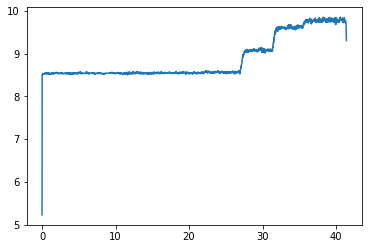

In [9]:
plt.plot(time, noisy)

In [25]:
clean_vmf = medfilt(noisy, kernel_size=251)

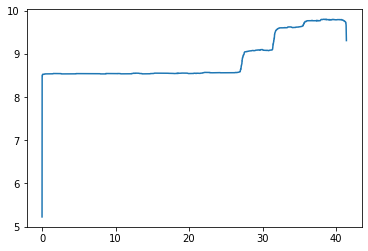

In [31]:
plt.plot(time, clean_vmf)

In [44]:
clean_sf = savgol_filter(noisy, window_length=251, polyorder=0)

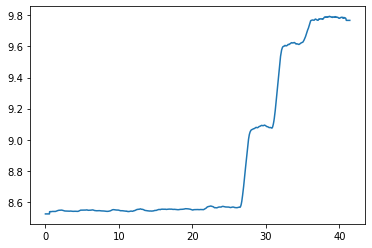

In [45]:
plt.plot(time, clean_sf)

In [57]:
clean_lowess = lowess(noisy, time, frac=0.05)

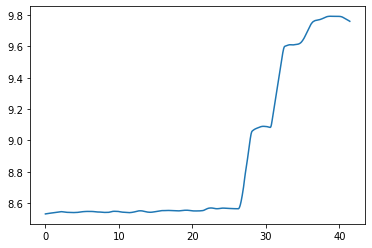

In [58]:
plt.plot(time, clean_lowess[:, 1])

In [106]:
initial_value_guess = noisy[100]
observation_covariance = np.diag([2]) ** 2
transition_covariance = np.diag([0.09]) ** 2
transition_matrix = [1]

kf = KalmanFilter(
    initial_state_mean=initial_value_guess,
    initial_state_covariance=observation_covariance,
    observation_covariance=observation_covariance,
    transition_covariance=transition_covariance,
    transition_matrices=transition_matrix
)
pred_state, state_cov = kf.smooth(noisy)

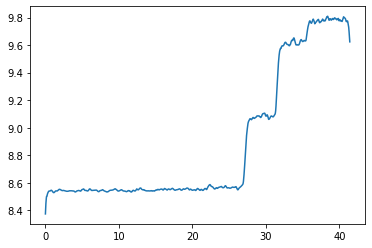

In [107]:
plt.plot(time, pred_state)

In [122]:
clean_wt = denoise_wavelet(noisy, sigma=0.2)

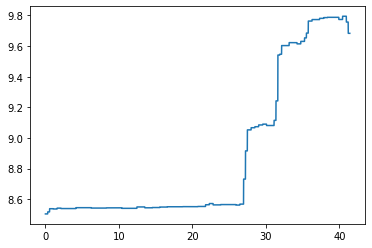

In [123]:
plt.plot(time, clean_wt)